In [1]:
%config InlineBackend.figure_format = "svg"

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Datafile treatment

Since the data comes in a single file, this portion of the code splits the data into two separate training and testing data files.

The index and the id columns are also irrelevant for the classification task, and therefore are dropped already in this step.

In [2]:
# Define datapaths
datapath = "data/healthcare-dataset-stroke-data.csv"
train_datapath = datapath.split(".")[0] + "-train.csv"
test_datapath = datapath.split(".")[0] + "-test.csv"

# Define some controlling variables
random_state = 0 # Ensure reproducibility
train_split = 0.8 # Percentage of training data

# Split the dataset into training and testing data, if the data file exists
if os.path.isfile(datapath):
    # Split data
    df = pd.read_csv(datapath)
    df_train = df.sample(frac=0.8, random_state=random_state)
    df_test = df.drop(df_train.index)
    
    # Save data to new paths
    df_train.reset_index().drop(columns=["index", "id"]).to_csv(train_datapath, index=False)
    df_test.reset_index().drop(columns=["index", "id"]).to_csv(test_datapath, index=False)
    
    # Remove previous datafile
    os.system(f"rm {datapath}")

## Initial data exploration

In [3]:
# Load datafile
df = pd.read_csv(train_datapath)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,82.0,0,1,Yes,Private,Urban,144.90,26.4,smokes,1
1,Male,4.0,0,0,No,children,Rural,106.22,16.7,Unknown,0
2,Male,58.0,0,0,Yes,Private,Urban,79.95,25.9,never smoked,0
3,Female,20.0,0,0,No,Private,Rural,96.57,34.1,never smoked,0
4,Female,10.0,0,0,No,children,Rural,69.84,13.7,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
4083,Female,51.0,0,0,Yes,Self-employed,Urban,232.89,34.0,smokes,0
4084,Male,64.0,0,1,Yes,Private,Urban,191.61,37.5,smokes,1
4085,Male,37.0,0,0,Yes,Self-employed,Rural,82.43,39.1,Unknown,0
4086,Female,22.0,0,0,No,Private,Rural,62.00,32.7,smokes,0


In [4]:
# Check dtypes of each column
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
# Quick dataset description of numeric columns
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4088.000000,4088.000000,4088.000000,4088.000000,3929.000000,4088.000000
mean,43.109207,0.099804,0.052593,106.290232,28.907126,0.047211
std,22.663296,0.299776,0.223247,45.431468,7.859276,0.212117
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.255000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.320000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
# Check whether dataset is balanced
true_perc = df.query("stroke == 1").shape[0] / df.shape[0]
print(f"{true_perc*100:.2f}% of the data points are positive.")

4.72% of the data points are positive.


A very small number of datapoint are positive. This dataset is definitely imbalaced. This should be accounted for in the training phase, otherwise the model will likely learn to classify data points as negative most of the time.

## Missing values

In [7]:
# Check number of NaN entries per column
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  159
smoking_status         0
stroke                 0
dtype: int64

The only column with NaN entries is the bmi column. Sometimes, missing values just represent a default to an entry that would otherwise not make sense (example: the size of the attic in a house without an attic.). This is not the case for this particular dataset, as every person has a bmi. Therefore, these values were simply not recorded.

Since only one column is missing from those NaN values, dropping the whole row would be a waste of a lot of valuable information. Therefore, a simple mean imputation method is chosen to deal with the missing values of this dataset (an imputation of a fixed value like 0% makes no sense in the context of a bmi).

In [8]:
# Split data into features and labels
feature_cols = [col for col in list(df.columns) if col!="stroke"]
X, y = df[feature_cols], df["stroke"]

# Get numeric features
num_features = [col for col in list(X.columns) if X[col].dtype in ["int64", "float64"]]
cat_features = [col for col in list(X.columns) if col not in num_features]

# Handle missing values (using mean imputation)
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X[num_features], y)

# Convert to df and append categorical features to imputed df
X_imputed = pd.DataFrame(X_imputed, columns=num_features)
X_imputed[cat_features] = X[cat_features]

# Check that features have been properly imputed
assert X_imputed.isnull().sum().sum() == 0, "Data not properly imputed"
X_imputed

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender,ever_married,work_type,Residence_type,smoking_status
0,82.0,0.0,1.0,144.90,26.4,Male,Yes,Private,Urban,smokes
1,4.0,0.0,0.0,106.22,16.7,Male,No,children,Rural,Unknown
2,58.0,0.0,0.0,79.95,25.9,Male,Yes,Private,Urban,never smoked
3,20.0,0.0,0.0,96.57,34.1,Female,No,Private,Rural,never smoked
4,10.0,0.0,0.0,69.84,13.7,Female,No,children,Rural,Unknown
...,...,...,...,...,...,...,...,...,...,...
4083,51.0,0.0,0.0,232.89,34.0,Female,Yes,Self-employed,Urban,smokes
4084,64.0,0.0,1.0,191.61,37.5,Male,Yes,Private,Urban,smokes
4085,37.0,0.0,0.0,82.43,39.1,Male,Yes,Self-employed,Rural,Unknown
4086,22.0,0.0,0.0,62.00,32.7,Female,No,Private,Rural,smokes


## Categorical data

In [9]:
for col in cat_features:
    unique_values = X_imputed[col].unique()
    print(f"Feature: {col} | Unique values: {unique_values}")

Feature: gender | Unique values: ['Male' 'Female']
Feature: ever_married | Unique values: ['Yes' 'No']
Feature: work_type | Unique values: ['Private' 'children' 'Govt_job' 'Self-employed' 'Never_worked']
Feature: Residence_type | Unique values: ['Urban' 'Rural']
Feature: smoking_status | Unique values: ['smokes' 'Unknown' 'never smoked' 'formerly smoked']


Notice that none of the categorical variables has an order in their categories. As such, ordinal encoding is not a good choice for the categorical variables.
It can be used, however, as a LabelEncoder for the binary categorical features, as it serves the same purpose.

The gender, ever_married and residence_type columns are binary, and therefore can use OrdinalEncoding.

The number of unique categories in the remainder features is low. Therefore, performing a one hot encoding on these columns of the data is a valid approach, as it will not significantly increase the number of columns of the dataset.

In [10]:
# Define new features
one_hot_features = ["work_type", "smoking_status"]
ordinal_features = [col for col in cat_features if col not in one_hot_features]

# Define one-hot encoder
one_hot_encoder = OneHotEncoder(handle_unknown="error", sparse=False)
X_onehot = one_hot_encoder.fit_transform(X_imputed[one_hot_features], y)

# Convert to dataframe
new_features = one_hot_encoder.get_feature_names_out(one_hot_features)
X_onehot = pd.DataFrame(X_onehot, columns=new_features)
X_onehot[ordinal_features] = X_imputed[ordinal_features]

# Define ordinal encoder
ordinal_encoder = OrdinalEncoder()
X_encoded = ordinal_encoder.fit_transform(X_imputed[ordinal_features], y)

# Convert to dataframe
X_encoded = pd.DataFrame(X_encoded, columns=ordinal_features)
X_encoded[new_features] = X_onehot[new_features]
X_encoded[num_features] = X_imputed[num_features]
X_encoded

,gender,ever_married,Residence_type,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,82.0,0.0,1.0,144.90,26.4
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,106.22,16.7
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,58.0,0.0,0.0,79.95,25.9
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,0.0,0.0,96.57,34.1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,10.0,0.0,0.0,69.84,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,51.0,0.0,0.0,232.89,34.0
4084,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,0.0,1.0,191.61,37.5
4085,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,37.0,0.0,0.0,82.43,39.1
4086,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,22.0,0.0,0.0,62.00,32.7


In [11]:
# Print all new features
X_encoded.columns

Index(['gender', 'ever_married', 'Residence_type', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'age',
       'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'],
      dtype='object')

## Univariate distribution analysis

In [28]:
def make_hist(X, y, ax, bins, col, norm):
    # Check if bins are more than unique values
    change_ticks = False
    x_ticks = X.unique()
    if x_ticks.shape[0] < bins:
        change_ticks = True
        bins = x_ticks.shape[0]
        
    # Get counts and bins for the histogram
    counts0, bins = np.histogram(X[y==0], bins)
    counts1, _ = np.histogram(X[y==1], bins)
    
    # Calculate heights
    if norm:
        h0 = counts0 / (counts0 + counts1 + 1e-6)
        h1 = counts1 / (counts0 + counts1 + 1e-6)
    else:
        h0 = counts0
        h1 = counts1
        
    # Add width and center bins
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    # Plot the data
    ax.bar(center, h1, width=width, label="positive", color="green", linewidth=.5, edgecolor="black")
    ax.bar(center, h0, width=width, bottom=h1, label="negative", color="red", linewidth=.5, edgecolor="black")
    
    # Change ticks if bins are more than unique values
    if change_ticks:
        ax.set_xticks(x_ticks)
    ax.set_xlabel(col)
    ax.legend()
    
    
def make_kde(X, y, ax, bins, col, norm):
    # Check if bins are more than unique values
    kde = True
    change_ticks = False
    x_ticks = X.unique()
    if x_ticks.shape[0] < bins:
        change_ticks = True
        bins = x_ticks.shape[0]
        kde = False
        
    # Get counts and bins for the histogram
    l_lim = min(X[y==0].min(), X[y==1].min())
    r_lim = max(X[y==0].max(), X[y==1].max())
    step = (r_lim - l_lim) / bins
    bins = np.arange(l_lim, r_lim+step, step)
    
    # Plot the data
    sns.histplot(X[y==0], bins=bins, kde=kde, label="negative", color="blue", ax=ax)
    sns.histplot(X[y==1], bins=bins, kde=kde, label="positive", color="orange", ax=ax)
    
    # Change ticks if bins are more than unique values
    if change_ticks:
        ax.set_xticks(x_ticks)
    ax.set_xlabel(col)
    ax.legend()

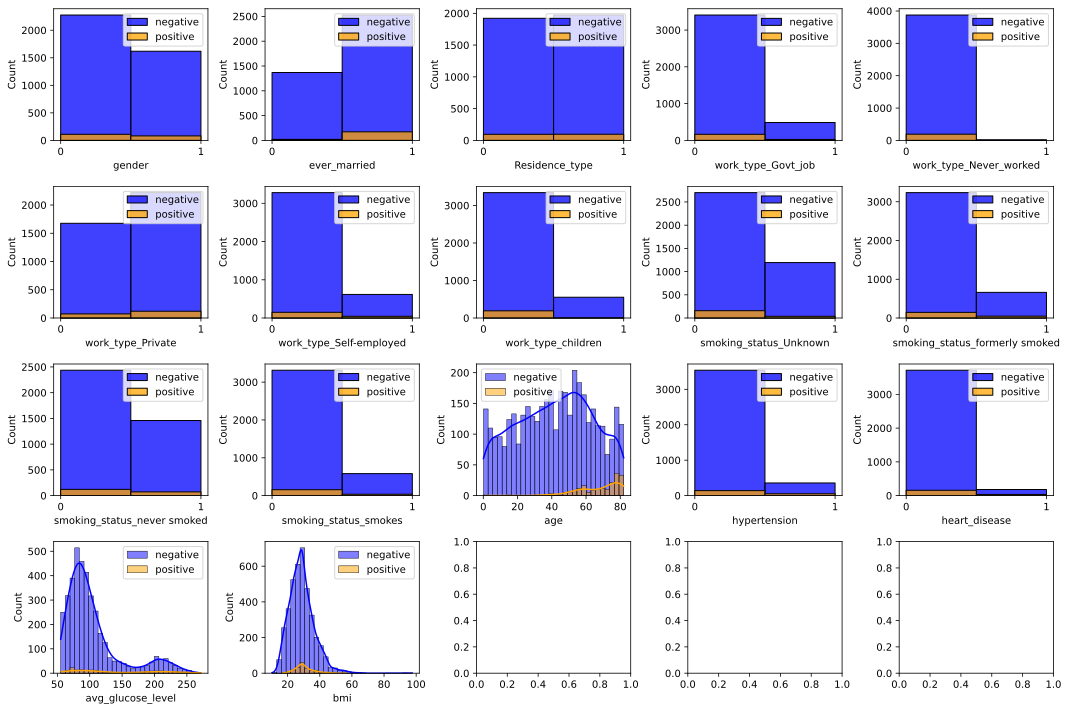

In [29]:
# Plot adjustment variables
num_cols, bins, norm, mode = 5, 30, True, "kde"

# Create figure
num_rows = int(np.ceil(len(X_encoded.columns) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Iterate and plot each columns
for i, column in enumerate(X_encoded.columns):
    row, col = int(i/num_cols), i%num_cols
    if mode == "hist":
        make_hist(X_encoded[column], y, axs[row,col], bins, column, norm)
    elif mode == "kde":
        make_kde(X_encoded[column], y, axs[row,col], bins, column, norm)
    
plt.tight_layout()
plt.show()

Interesting conclusions from the data distributions:
- Strokes seem to be more frequent in Females
- Strokes are more frequent in the more elderly
- Having smoked might slightly increase the change of a stroke (although might just be statistic fluctuation)
- Having hypertension or heart diseas significantly increases the chances of having a stroke
- Having a high gluscose level also seems to increase stroke changes
- Curiously, people from this sample who have been married seem to have a higher change of having a stroke